# Boas práticas

## Refatorando: funções, tipagem, PEP8 e Flake

In [5]:
import matplotlib.pyplot as plt
from typing import Callable
import numpy as np
import pandas as pd
import statsmodels.stats.diagnostic as diag
import statsmodels.tsa.stattools as sm
from scipy import optimize
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import (
    explained_variance_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error
)
from sktime.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sktime.datatypes import convert
from sktime.datasets import load_airline
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.series.boxcox import BoxCoxTransformer, LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

In [6]:
import warnings
warnings.filterwarnings('ignore')

- Use funções para evitar repetições de código. DRY
- Documente as funções. Plugins: AutoDocString e Better Comments
- Dê nomes sugestíveis à variáveis
- Faça a tipagem da função. Facilita a correção no Visual code.
- Coloque operadores entre espaço. Flake8 (E226)
- Organize os imports em ordem alfabética. Plugin: isort
- Faça apenas os imports que você vai utilizar. Flake8(F401)

In [7]:
def preprocessing_date(
        data: pd.DataFrame,
        period: str,
        date_column_name: str = "Date") -> pd.DataFrame:
    """Return data with Date feature in index.

    Args:
        data (pd.DataFrame): Data with a "Date" column
        period (str): "D", "M", "Y"
        date_column_name (str): Default is "Date"
    """
    data_copy = data.copy()
    data_copy[date_column_name] = pd.to_datetime(data_copy[date_column_name])
    data_copy[date_column_name] = data_copy[date_column_name].dt.to_period(period)
    data_copy.set_index(date_column_name, inplace=True)
    return data_copy


def make_transformations(
    y: pd.Series,
) -> tuple[pd.Series, Callable[[pd.Series], pd.Series]]:
    """Make usual transformations on serie

    Args:
        y (pd.Series): A serie in a sktime format.

    Returns:
        tuple[pd.Series, Callable[[pd.Series], pd.Series]]: A transformed serie
        and a function to invert the transformation
    """
    y_copy = y.copy()
    y_mean = y.mean()
    y_std = y.std()
    log_transform = LogTransformer()
    trend_transform = Detrender()
    deseason_transform = Deseasonalizer()
    y_copy = log_transform.fit_transform(y_copy)
    y_copy = trend_transform.fit_transform(y_copy)
    y_copy = deseason_transform.fit_transform(y_copy)
    y_copy = (y_copy - y_mean) / y_std

    def inverse_transformation(serie):
        serie_copy = serie.copy()
        serie_copy = serie_copy * y_std + y_mean
        serie_copy = deseason_transform.inverse_transform(serie_copy)
        serie_copy = trend_transform.inverse_transform(serie_copy)
        serie_copy = log_transform.inverse_transform(serie_copy)
        return serie_copy

    return y_copy, inverse_transformation

In [8]:
# get series and preprocessing date
train = pd.read_csv('../datasets/godaddy/train.csv')
train = preprocessing_date(
    data=train, 
    period="M",
    date_column_name="first_day_of_month")
train.head()

,row_id,cfips,county,state,microbusiness_density,active
first_day_of_month,,,,,,
2019-08,1001_2019-08-01,1001,Autauga County,Alabama,3.007682,1249
2019-09,1001_2019-09-01,1001,Autauga County,Alabama,2.884870,1198
2019-10,1001_2019-10-01,1001,Autauga County,Alabama,3.055843,1269
2019-11,1001_2019-11-01,1001,Autauga County,Alabama,2.993233,1243
2019-12,1001_2019-12-01,1001,Autauga County,Alabama,2.993233,1243


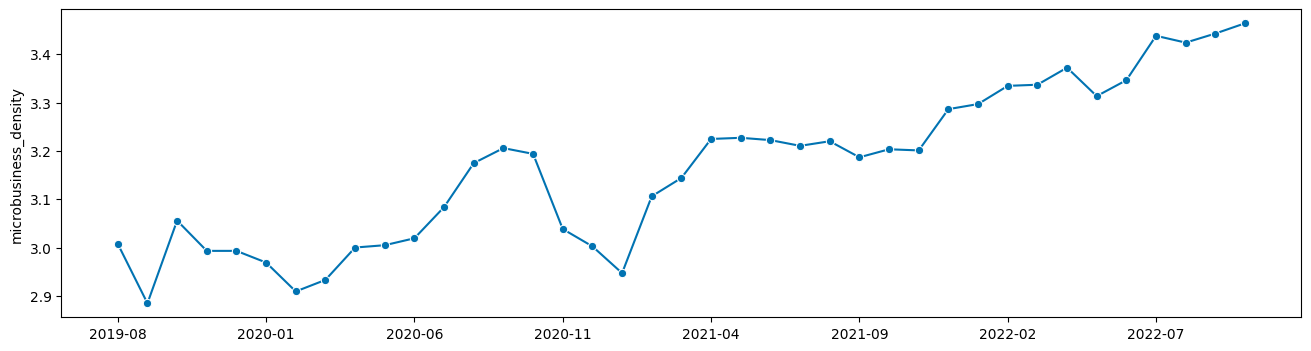

In [9]:
# show original serie
y = train[train['cfips'] == 1001]['microbusiness_density']
plot_series(y)
plt.show()

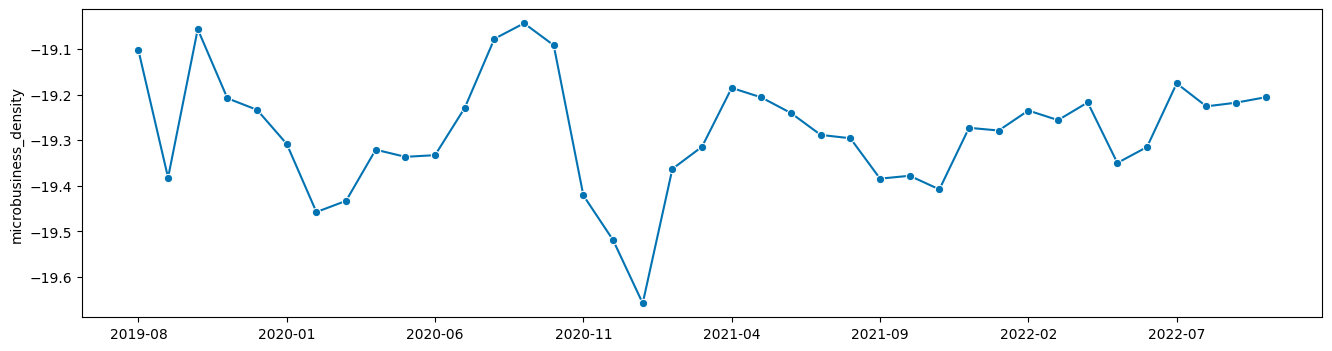

In [10]:
# show transformed serie
transformed_y, inverse_transformation = make_transformations(y)
plot_series(transformed_y)
plt.show()

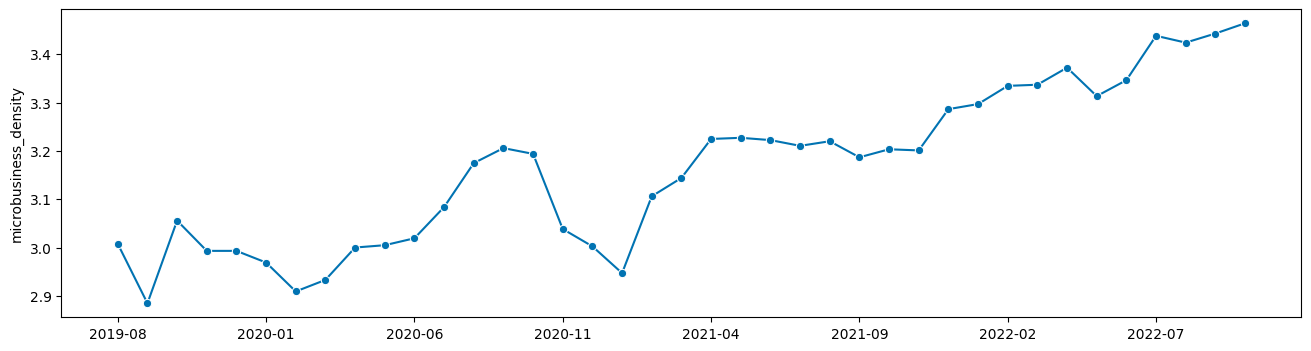

In [11]:
plot_series(inverse_transformation(transformed_y))
plt.show()

## Pipelines

In [12]:
# data
df = pd.DataFrame(columns=['x1','x2','y'], data=[
    [1,16,9],
    [4,36,16],
    [1,16,9],
    [2,9,8],
    [3,36,15],
    [2,49,16],
    [4,25,14],
    [5,36,17]
]) # y = x1 + 2 * sqrt(x2)

# train test split function
def get_train_test():
    train = df.iloc[:6]
    test = df.iloc[6:]

    train_X = train.drop('y', axis=1)
    train_y = train.y

    test_X = test.drop('y', axis=1)
    test_y = test.y
    return train_X, train_y, test_X, test_y

### Treinando regressão linear

In [13]:
train_X, train_y, test_X, test_y = get_train_test()

model = LinearRegression()
model_fit = model.fit(train_X, train_y)
pred_y = model_fit.predict(test_X)
error = mean_squared_error(pred_y, test_y, squared=False)
print("RMSE:", round(error,4))

RMSE: 0.2027


In [14]:
pred_y

array([13.72113586, 16.93334467])

### Treinando regressão linear com engenharia de variável

In [15]:
train_X, train_y, test_X, test_y = get_train_test()

# preprocessando x2
train_X.x2 = 2 * np.sqrt(train_X.x2)
test_X.x2 = 2 * np.sqrt(test_X.x2)

model = LinearRegression()
model_fit = model.fit(train_X, train_y)
pred_y = model_fit.predict(test_X)
error = mean_squared_error(pred_y, test_y, squared=False)
print("RMSE:", round(error,4))

RMSE: 0.0


In [16]:
pred_y

array([14., 17.])

### Regressão linear com Pipeline

In [17]:
train_X, train_y, test_X, test_y = get_train_test()

pipe = Pipeline(steps=[
    ('linear_model', LinearRegression())
])

pipe_fit = pipe.fit(train_X, train_y)
pred_y = pipe_fit.predict(test_X)
error = mean_squared_error(pred_y, test_y, squared=False)
print("RMSE:", round(error,4))

RMSE: 0.2027


### Regressão linear e engenharia de variável com Pipeline

In [18]:
class DummyTransformer(BaseEstimator, TransformerMixin):
  """
      Dummy class that allows us to modify only the methods 
      that interest us, avoiding redudancy.
  """
  def __init__(self):
    return None

  def fit(self, X=None, y=None):
    return self

  def transform(self, X=None):
    return self

class TwiceSqrt(DummyTransformer):
  """
      Class used to twice of sqrt of some feature
  """
  def __init__(self, feature_name: str = 'x2'):
    self.feature_name = feature_name
    return None

  def transform(self, X=None):
    preprocessed = X.copy()
    preprocessed[self.feature_name] = 2 * np.sqrt(preprocessed[self.feature_name])
    return preprocessed

In [19]:
train_X, train_y, test_X, test_y = get_train_test()

pipe = Pipeline(steps=[
    ('twice_sqrt', TwiceSqrt()),
    ('linear_model', LinearRegression()),
])

pipe_fit = pipe.fit(train_X, train_y)
pred_y = pipe_fit.predict(test_X)
error = mean_squared_error(pred_y, test_y, squared=False)
print("RMSE:", round(error,4))

RMSE: 0.0


### Tunando pipelines (GridSearch)

<b>Pipeline com Ridge</b>

In [20]:
train_X, train_y, test_X, test_y = get_train_test()

pipe = Pipeline(steps=[
    ('twice_sqrt', TwiceSqrt()),
    ('ridge', Ridge()),
])

pipe_fit = pipe.fit(train_X, train_y)
pred_y = pipe_fit.predict(test_X)
error = mean_squared_error(pred_y, test_y, squared=False)
print("RMSE:", round(error,4))

RMSE: 0.3189


<b>Tunando pipeline com Ridge</b>

In [21]:
pipe = Pipeline([
    ('twice_sqrt', TwiceSqrt()),
    ('ridge', Ridge())])

param_grid = {
    'twice_sqrt__feature_name': ['x1', 'x2'],
    'ridge__alpha': [0,0.5,1]}
search = GridSearchCV(pipe, param_grid, cv=2).fit(
    train_X, train_y)
search.best_params_

{'ridge__alpha': 0, 'twice_sqrt__feature_name': 'x2'}

<b>Avaliando pipeline tunado</b>

In [22]:
train_X, train_y, test_X, test_y = get_train_test()

pipe = Pipeline([
    ('twice_sqrt', TwiceSqrt(feature_name='x2')),
    ('knn_regressor', Ridge(alpha=0))])

pipe_fit = pipe.fit(train_X, train_y)
pred_y = pipe_fit.predict(test_X)
error = mean_squared_error(pred_y, test_y, squared=False)
print("RMSE:", round(error,4))

RMSE: 0.0


### Pipelines com Sktime

<b>Caso de uma única variável endôgenea</b>

In [24]:
class StandardScale(DummyTransformer):
  """
      Class used to standard scale y
  """

  def transform(self, y=None):
    y_norm = y.copy()
    y_norm = (y_norm - y_norm.mean()) / y_norm.std()
    return y_norm

  def inverse_transform(self, y=None): # precisa
    y_norm_inv = y.copy()
    y_norm_inv = y_norm_inv * y_norm_inv.std() + y_norm_inv.mean()
    return y_norm_inv

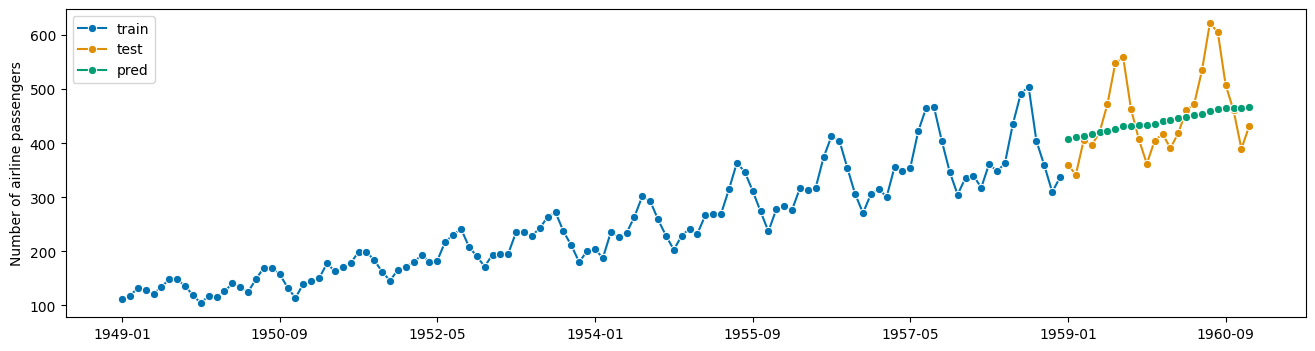

CPU times: total: 766 ms
Wall time: 7.32 s


In [25]:
%%time
y = load_airline()

pipe = make_pipeline(
    Detrender(),
    Deseasonalizer(),
    StandardScale(),
    AutoARIMA()
)

y_train, y_test = temporal_train_test_split(
    y, test_size=24)

pipe_fit = pipe.fit(y)
y_pred = pipe_fit.predict(y_test.index)

plot_series(
    y_train, y_test, y_pred, 
    labels=['train', 'test', 'pred'])
plt.show()

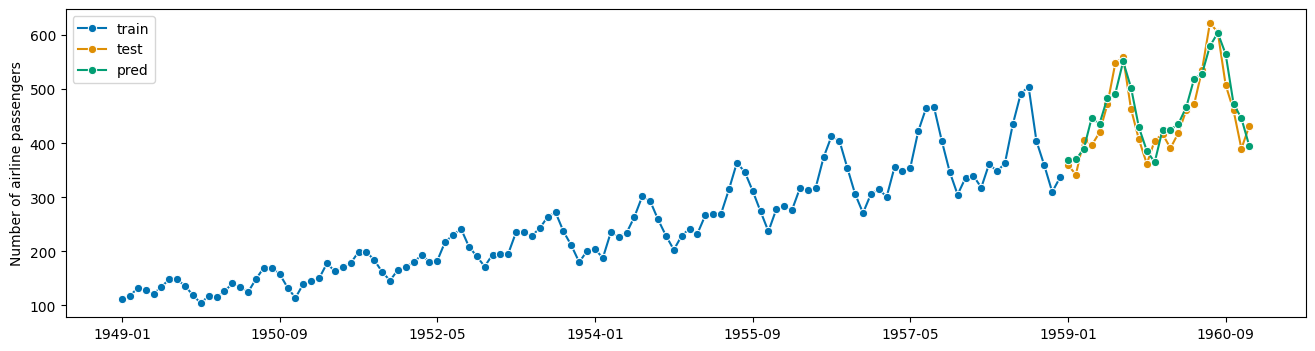

CPU times: total: 922 ms
Wall time: 6.55 s


In [27]:
%%time
y = load_airline()

pipe = make_pipeline(
    LogTransformer(),
    Detrender(),
    Deseasonalizer(),
    AutoARIMA()
)

y_train, y_test = temporal_train_test_split(y, test_size=24)

pipe_fit = pipe.fit(y)
y_pred = pipe_fit.predict(y_test.index)

plot_series(y_train, y_test, y_pred, labels=['train', 'test', 'pred'])
plt.show()

## Exercício

Faça uma submissão no desafio usando pipelines e adotando boas práticas para funções como tipagem e documentação https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales

## Referências
- https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156
- https://towardsdatascience.com/customizing-sklearn-pipelines-transformermixin-a54341d8d624